In [9]:
import numpy as np
import matplotlib.pyplot as plt
from track2obstacles import smooth_track, ConvexHull
import jax
import jax.numpy as jnp

racing_tracks = {
    "track1": jnp.array(
        [
            [1.0, 1.0],
            [2.0, 1.0],
            [3.0, 2.0],
            [4.0, 2.0],
            [5.0, 3.0],
            [6.0, 3.0],
            [7.0, 4.0],
            [6.0, 5.0],
            [5.0, 5.0],
            [4.0, 6.0],
            [3.0, 6.0],
            [2.0, 5.0],
            [1.0, 5.0],
            [1.0, 4.0],
        ]
    ),
    "track2": jnp.array(
        [
            [0, 0],
            [5.00, 0],
            [5.00, 0.5],
            [5.00, 1.5],
            [5.00, 5.00],
            [10.00, 10.00],
            [9.00, 10.00],
            [5.00, 10.00],
            [15.00, 0],
        ]
    ),
}


def analyze_and_plot(npz_file):
    # Load the simulation data
    data = np.load(npz_file, allow_pickle=True)
    states_history = data["states_history"]
    config = data["config"].item()

    # print(config)

    points = racing_tracks[config["track"]]
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]

    smooth_points = smooth_track(hull_points)
    # waypoints = smooth_points[:: config["waypoints_discretization"]]
    # print(config)
    waypoints = config["waypoints"]
    # (1) Count passed waypoints
    passed_waypoints = 0
    current_waypoint_index = 0
    threshold = config["accept_waypoint_dist"]
    num_waypoints = waypoints.shape[0]

    for state in states_history:
        if current_waypoint_index >= num_waypoints:
            current_waypoint_index = 0

        waypoint = waypoints[current_waypoint_index]
        distance = np.linalg.norm(state[:2] - waypoint)
        if distance < threshold:
            passed_waypoints += 1
            current_waypoint_index += 1

    # (2) Calculate average speed
    average_speed = np.mean(states_history[:, 3])  # Speed is the fourth state variable

    # (3) Calculate average perpendicular distance from the central line
    distances = []
    for state in states_history:
        point = state[:2]
        min_distance = np.min(
            np.linalg.norm(smooth_points - point, axis=1)
        )  # Closest point on the central line
        distances.append(min_distance)
    # avg_distance_from_central = np.sum(distances)
    avg_distance_from_central = np.mean(distances)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.title("Trajectory Analysis")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.plot(
        smooth_points[:, 0],
        smooth_points[:, 1],
        label="Central Line",
        linestyle="--",
        color="black",
    )
    plt.plot(
        states_history[:, 0],
        states_history[:, 1],
        label="Trajectory",
        color="blue",
    )
    plt.scatter(
        waypoints[:, 0], waypoints[:, 1], label="Waypoints", color="red", zorder=5
    )

    # if obstacles are enabled, we should add them to the plot
    if config["enable_obstacles"]:
        obstacles = config["obstacles"]
        for obstacle in obstacles:
            circle = plt.Circle(
                (obstacle[0], obstacle[1]),
                config["obstacle_radius"],
                color="gray",
                fill=False,
                alpha=0.6,
            )
            plt.gca().add_artist(circle)

        # for obstacle in obstacles:
        # plt.scatter(obstacles[:, 0], obstacles[:, 1], label="Obstacle", color="gray", zorder=15)

    plt.legend()
    plt.grid()
    plt.show()

    return passed_waypoints, average_speed, avg_distance_from_central

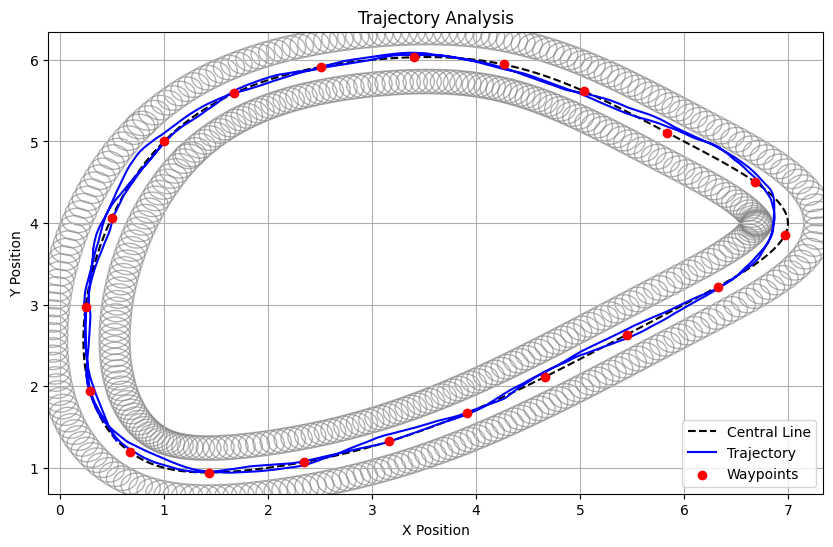

File: data/track1_obs_none.npz, Passed Waypoints: 45, Average Speed: 0.812961220741272, Average Distance from Central Line: 0.04005515826356067


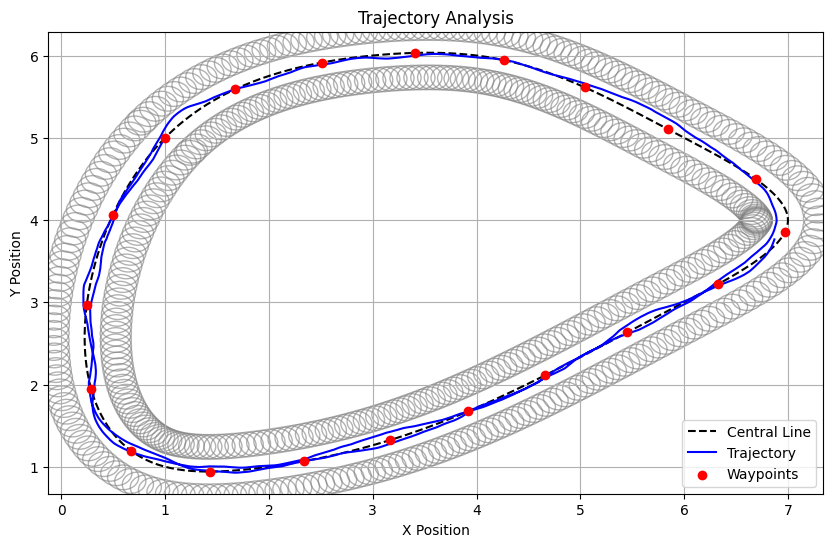

File: data/track1_obs_pure.npz, Passed Waypoints: 33, Average Speed: 0.592542290687561, Average Distance from Central Line: 0.04079030835550794


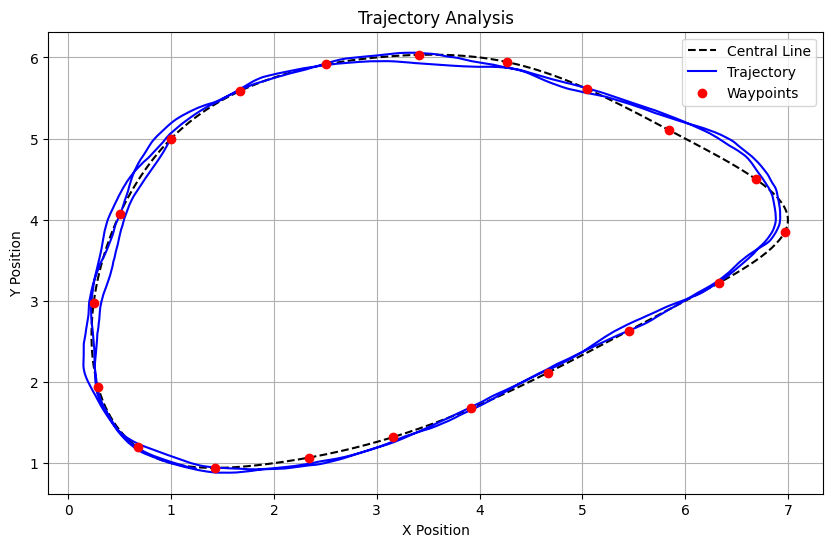

File: data/track1_no_obs_none.npz, Passed Waypoints: 46, Average Speed: 0.8355175852775574, Average Distance from Central Line: 0.05514016274663186


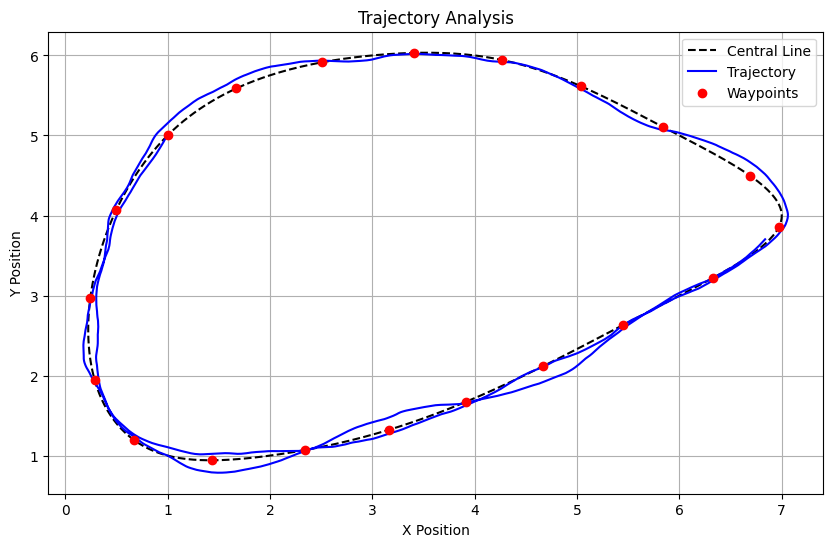

File: data/track1_no_obs_pure.npz, Passed Waypoints: 33, Average Speed: 0.5978548526763916, Average Distance from Central Line: 0.05410538689246751


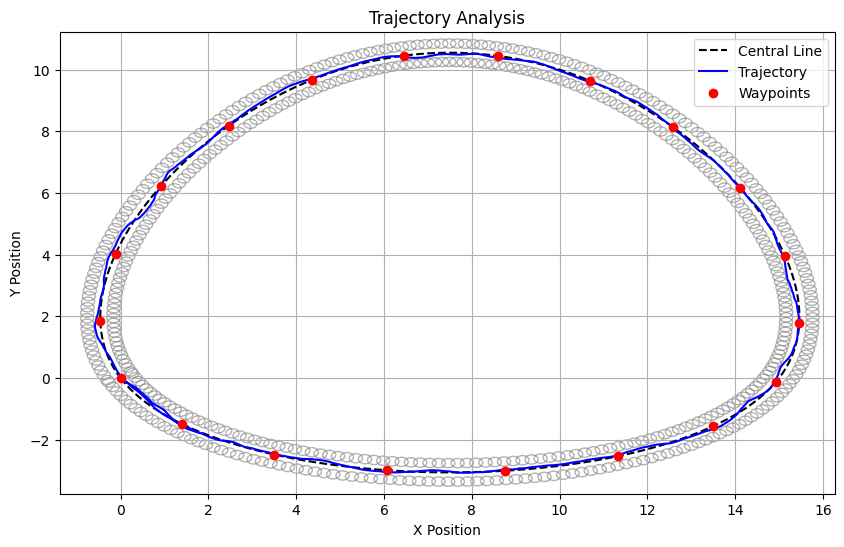

File: data/track2_obs_none.npz, Passed Waypoints: 22, Average Speed: 0.9887138605117798, Average Distance from Central Line: 0.05542698028384908


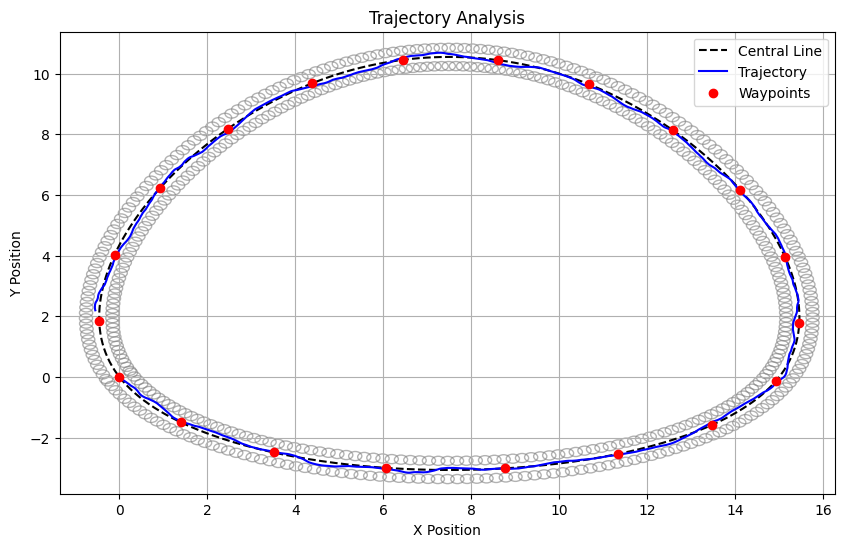

File: data/track2_obs_pure.npz, Passed Waypoints: 19, Average Speed: 0.8920997977256775, Average Distance from Central Line: 0.06251900142676381


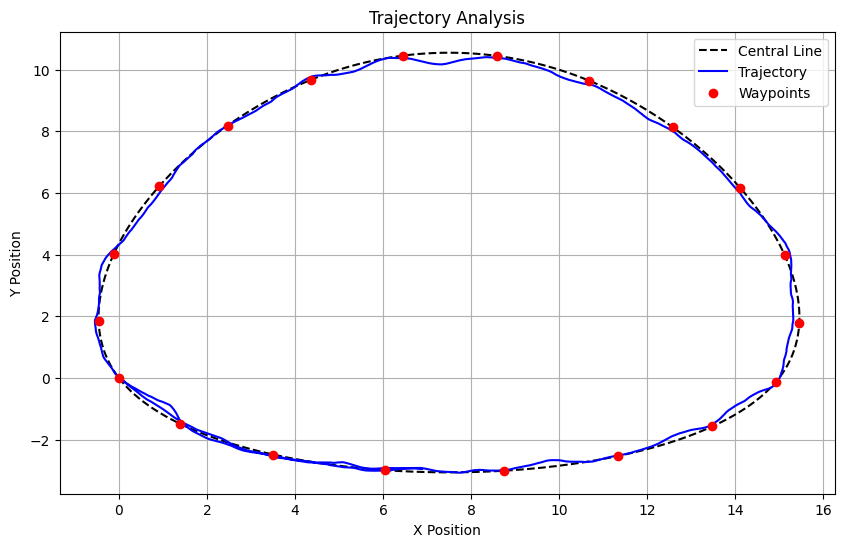

File: data/track2_no_obs_none.npz, Passed Waypoints: 24, Average Speed: 1.0941834449768066, Average Distance from Central Line: 0.0929801066416939


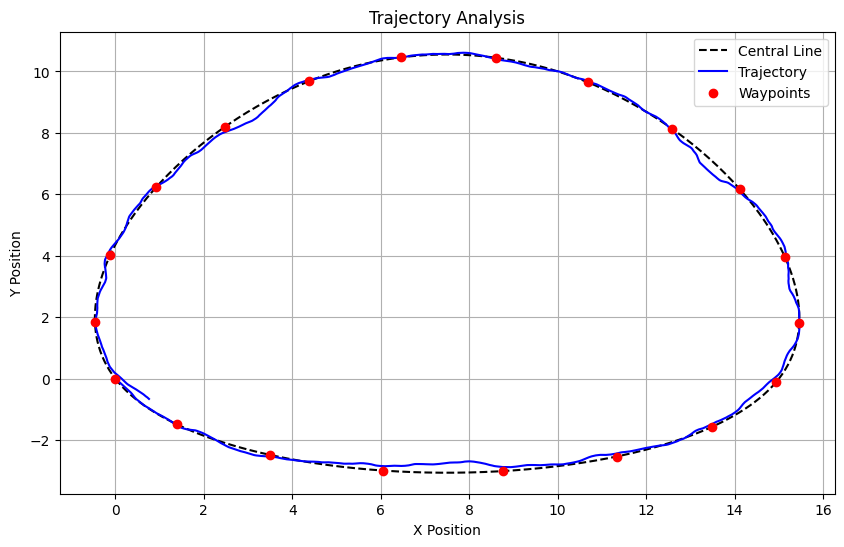

File: data/track2_no_obs_pure.npz, Passed Waypoints: 21, Average Speed: 0.9572736024856567, Average Distance from Central Line: 0.08587538933115778
Results:
{'file': 'data/track1_obs_none.npz', 'passed_waypoints': 45, 'average_speed': 0.8129612, 'avg_distance_from_central': 0.04005515826356067, 'obstacles': 'Enabled', 'track': 'Track 1', 'angle_regulation': 'None'}
{'file': 'data/track1_obs_pure.npz', 'passed_waypoints': 33, 'average_speed': 0.5925423, 'avg_distance_from_central': 0.04079030835550794, 'obstacles': 'Enabled', 'track': 'Track 1', 'angle_regulation': 'Pure Pursuit'}
{'file': 'data/track1_no_obs_none.npz', 'passed_waypoints': 46, 'average_speed': 0.8355176, 'avg_distance_from_central': 0.05514016274663186, 'obstacles': 'None', 'track': 'Track 1', 'angle_regulation': 'None'}
{'file': 'data/track1_no_obs_pure.npz', 'passed_waypoints': 33, 'average_speed': 0.59785485, 'avg_distance_from_central': 0.05410538689246751, 'obstacles': 'None', 'track': 'Track 1', 'angle_regulation'

In [11]:
results = [
    {
        "file": "data/track1_obs_none.npz",
    },
    {
        "file": "data/track1_obs_pure.npz",
    },
    {
        "file": "data/track1_no_obs_none.npz",
    },
    {
        "file": "data/track1_no_obs_pure.npz",
    },
    {
        "file": "data/track2_obs_none.npz",
    },
    {
        "file": "data/track2_obs_pure.npz",
    },
    {
        "file": "data/track2_no_obs_none.npz",
    },
    {
        "file": "data/track2_no_obs_pure.npz",
    },
]

# for each of entry set parameters: obstacles, track, angle regulation, average speed, number of passed waypoints
for result in results:
    passed_waypoints, average_speed, avg_distance_from_central = analyze_and_plot(
        result["file"]
    )
    print(
        f"File: {result['file']}, Passed Waypoints: {passed_waypoints}, Average Speed: {average_speed}, Average Distance from Central Line: {avg_distance_from_central}"
    )
    # update the dictionary with the results
    result["passed_waypoints"] = passed_waypoints
    result["average_speed"] = average_speed
    result["avg_distance_from_central"] = avg_distance_from_central
    result["obstacles"] = "None" if "no_obs" in result["file"] else "Enabled"
    result["track"] = "Track 1" if "track1" in result["file"] else "Track 2"
    result["angle_regulation"] = "None" if "none" in result["file"] else "Pure Pursuit"

# print the results
print("Results:")
for result in results:
    print(result)

In [14]:
import pandas

df = pandas.DataFrame(results)
display(df)

,file,passed_waypoints,average_speed,avg_distance_from_central,obstacles,track,angle_regulation
0,data/track1_obs_none.npz,45,0.812961,0.040055,Enabled,Track 1,None
1,data/track1_obs_pure.npz,33,0.592542,0.040790,Enabled,Track 1,Pure Pursuit
2,data/track1_no_obs_none.npz,46,0.835518,0.055140,None,Track 1,None
3,data/track1_no_obs_pure.npz,33,0.597855,0.054105,None,Track 1,Pure Pursuit
4,data/track2_obs_none.npz,22,0.988714,0.055427,Enabled,Track 2,None
5,data/track2_obs_pure.npz,19,0.892100,0.062519,Enabled,Track 2,Pure Pursuit
6,data/track2_no_obs_none.npz,24,1.094183,0.092980,None,Track 2,None
7,data/track2_no_obs_pure.npz,21,0.957274,0.085875,None,Track 2,Pure Pursuit


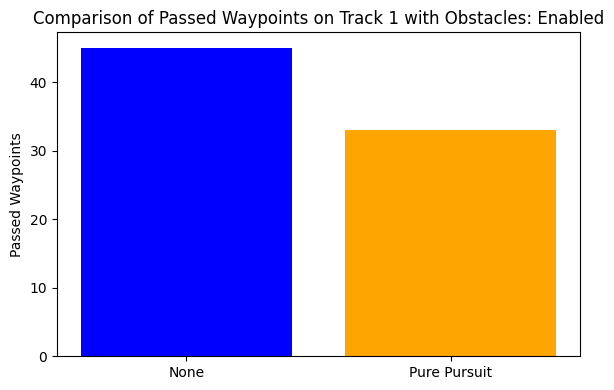

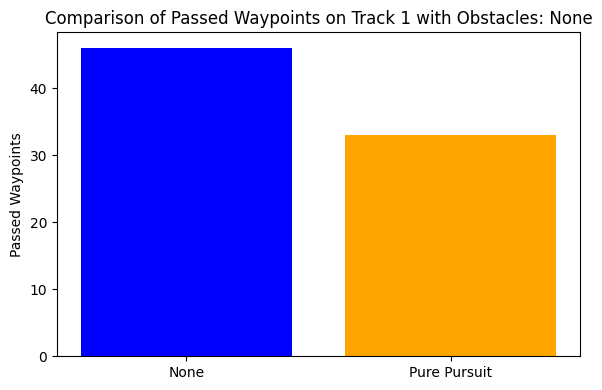

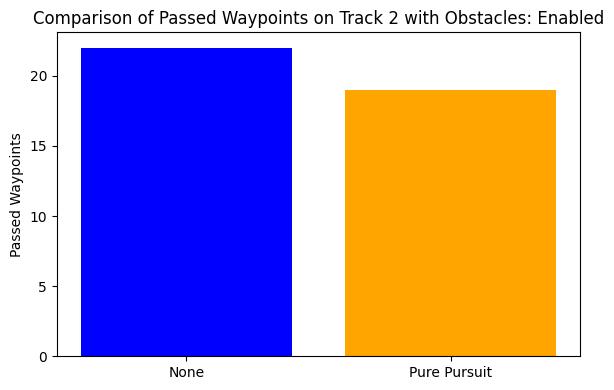

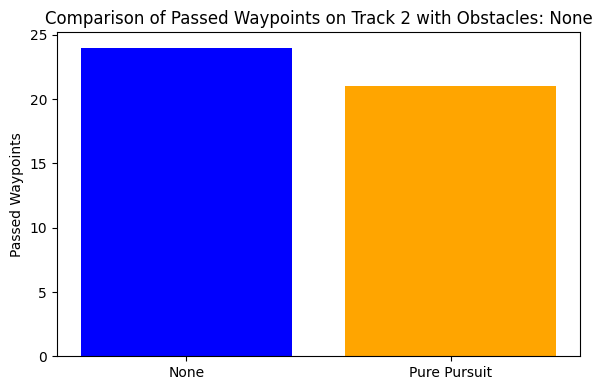

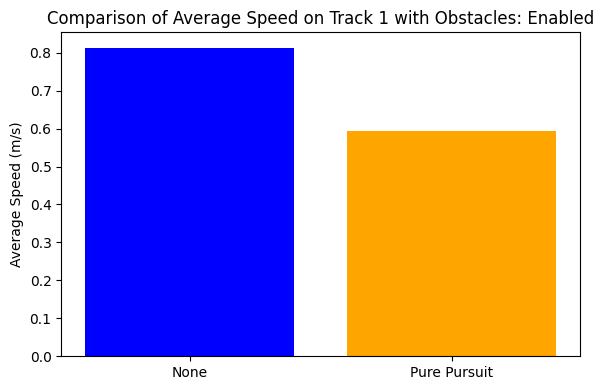

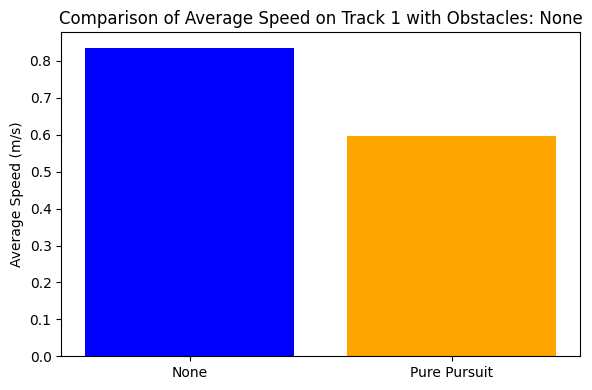

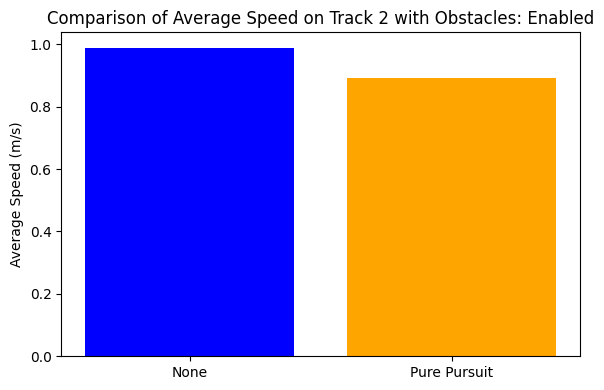

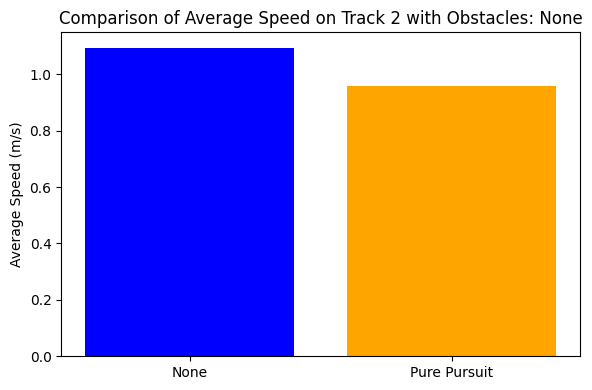

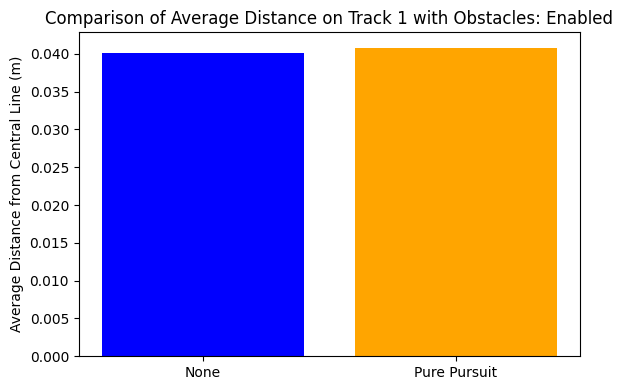

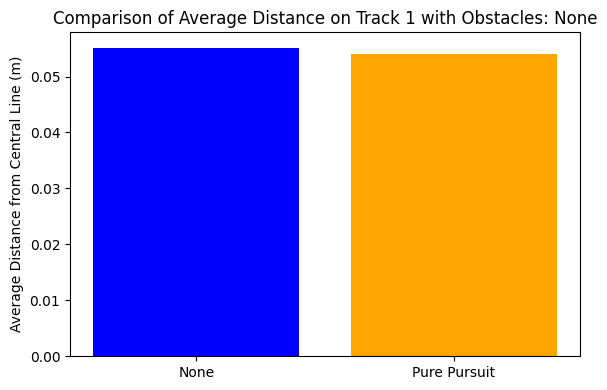

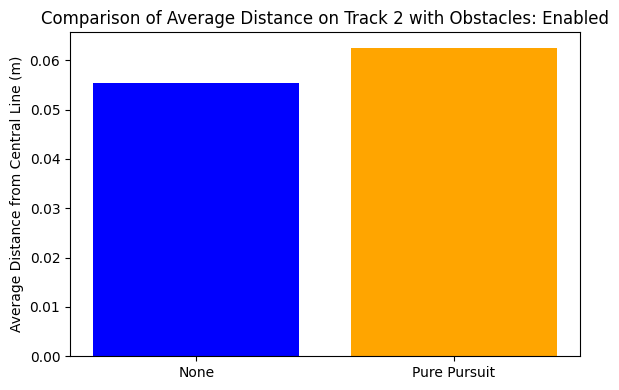

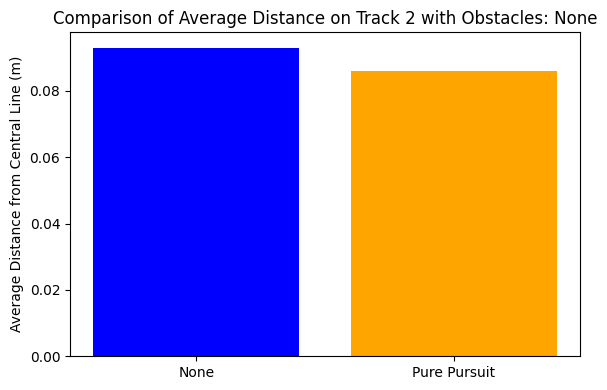

In [15]:
# Function to plot comparisons
def plot_comparison(metric, ylabel, title):
    tracks = df["track"].unique()
    for track in tracks:
        df_track = df[df["track"] == track]
        for obstacle_status in ["Enabled", "None"]:
            df_obstacle = df_track[df_track["obstacles"] == obstacle_status]
            methods = df_obstacle["angle_regulation"].unique()
            values = []
            for method in methods:
                value = df_obstacle[df_obstacle["angle_regulation"] == method][
                    metric
                ].values
                values.append(value[0] if len(value) > 0 else 0)
            plt.figure(figsize=(6, 4))
            plt.bar(methods, values, color=["blue", "orange"])
            plt.ylabel(ylabel)
            plt.title(f"{title} on {track} with Obstacles: {obstacle_status}")
            plt.tight_layout()
            plt.show()


# Plot Passed Waypoints
plot_comparison(
    "passed_waypoints", "Passed Waypoints", "Comparison of Passed Waypoints"
)

# Plot Average Speed
plot_comparison("average_speed", "Average Speed (m/s)", "Comparison of Average Speed")

# Plot Average Distance from Central Line
plot_comparison(
    "avg_distance_from_central",
    "Average Distance from Central Line (m)",
    "Comparison of Average Distance",
)

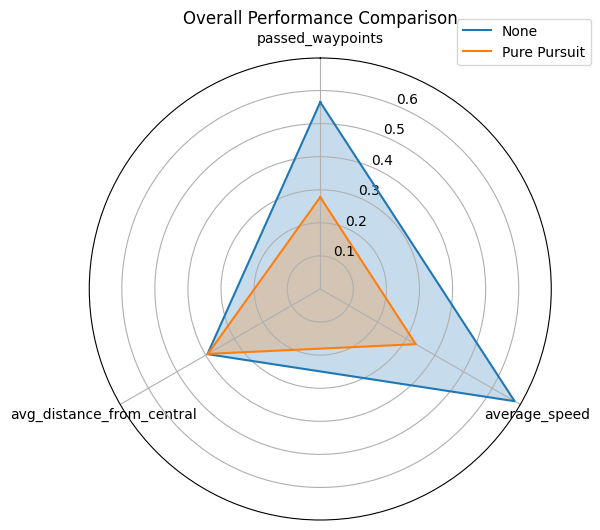

In [17]:
# Normalize the metrics for comparison
from sklearn.preprocessing import MinMaxScaler

metrics = ["passed_waypoints", "average_speed", "avg_distance_from_central"]
scaler = MinMaxScaler()
df_normalized = df.copy()
df_normalized[metrics] = scaler.fit_transform(df[metrics])

# Prepare data for radar chart
methods = df_normalized["angle_regulation"].unique()
labels = metrics
num_vars = len(labels)


# Function to create a radar chart
def create_radar_chart(df, title):
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    for method in methods:
        values = df[df["angle_regulation"] == method][metrics].mean().tolist()
        values += values[:1]
        ax.plot(angles, values, label=method)
        ax.fill(angles, values, alpha=0.25)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_title(title)
    ax.grid(True)
    plt.legend(loc="upper right", bbox_to_anchor=(1.1, 1.1))
    plt.show()


# Combine all data and create the radar chart
create_radar_chart(df_normalized, "Overall Performance Comparison")